In [1]:
import geopandas as gpd
import pandas as pd
import os
import glob
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
import numpy as np
import torch

In [3]:
device = "cuda:0"

In [4]:
footprints = gpd.read_file("footprints.geojson")

In [5]:
footprints

,id,geometry
0,2989080633810036413,"POLYGON ((-73.93425 40.66195, -73.93431 40.662..."
1,9831628575705046469,"POLYGON ((-73.98221 40.74505, -73.98252 40.745..."
2,13984590206613124140,"POLYGON ((-73.96395 40.75843, -73.96427 40.758..."
3,9876867656163658200,"POLYGON ((-73.91219 40.84347, -73.91227 40.843..."
4,15121519975208468876,"POLYGON ((-73.97142 40.78633, -73.97159 40.786..."
...,...,...
21345,13569713358266207507,"POLYGON ((-73.77341 40.78938, -73.77347 40.789..."
21346,13569713358266207507,"POLYGON ((-73.72464 40.76020, -73.72466 40.760..."
21347,13569713358266207507,"POLYGON ((-73.72455 40.76039, -73.72456 40.760..."
21348,13569713358266207507,"POLYGON ((-73.84834 40.71650, -73.84837 40.716..."


In [6]:
energy = pd.read_csv("energy.csv")
energy.footprint_id = energy.footprint_id.astype(str)

In [7]:
# now doing something with the streetview images

In [8]:
panodata = pd.read_csv("panopticdata.csv")
panodata

,Unnamed: 0,building_area,car_area,road_area,traffic sign_area,sidewalk_area,sky_area,wall_area,rider_area,bicycle_area,...,pole_counts,bicycle_counts,rider_counts,traffic sign_counts,sidewalk_counts,bus_counts,vegetation_counts,motorcycle_counts,wall_counts,train_counts
0,0,0.14010,0.03188,0.41158,0.00112,0.00777,0.29129,0.01105,0.00034,0.00026,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.16279,0.03549,0.31478,0.00016,0.00830,0.13632,0.00563,0.00000,0.00000,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.14872,0.00121,0.35610,0.00000,0.02799,0.33055,0.00000,0.00000,0.00000,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0.03872,0.00487,0.42003,0.00019,0.00000,0.38473,0.00000,0.00000,0.00000,...,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0
4,4,0.31635,0.02832,0.42079,0.00072,0.00792,0.17568,0.00000,0.00050,0.00190,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55755,55755,0.29363,0.03956,0.20964,0.00095,0.01302,0.19797,0.00000,0.00000,0.00035,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
55756,55756,0.00000,0.00684,0.39946,0.00000,0.00371,0.00000,0.00000,0.00042,0.00131,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
55757,55757,0.39880,0.02686,0.34503,0.00080,0.02202,0.14664,0.00000,0.00000,0.00000,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
55758,55758,0.00000,0.03833,0.39681,0.00036,0.01812,0.28289,0.00000,0.00000,0.00019,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [11]:
metadata_pd = pd.read_csv(
    "manhattan_metadata_nodes.tsv", 
    sep="\t"
)

metadata = gpd.GeoDataFrame(
    metadata_pd,
    geometry=gpd.points_from_xy(
        metadata_pd["snapped_coords.lng"], 
        metadata_pd["snapped_coords.lat"]),
    crs="EPSG:4326"
).to_crs(32618)

In [12]:
metadata.loc[:, ['pano_id', 'alt', 'roll_deg', 'pitch_deg', 'heading_deg', 'pano_date','geometry']].to_file("nodes.geojson")

In [13]:
nodes = gpd.read_file("nodes.geojson")

In [14]:
n = 0

footprints_range = footprints[:1000]
footprints_range["geometry"] = footprints_range.geometry.to_crs(32618).buffer(40)

footprints_data = footprints_range.merge(
    energy, 
    left_on="id", 
    right_on="footprint_id", 
    how="inner"
).drop(columns=['footprint_id'])

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
nodedata = nodes.merge(
    panodata,
    left_on="pano_id",
    right_on="id"
)

In [16]:
merged = gpd.sjoin(footprints_data, metadata, predicate='contains', how="inner")

In [17]:
merged_buildings = merged.drop_duplicates(subset=['id'])

In [18]:
joined = pd.concat([
    merged.drop_duplicates(subset="geometry").geometry,
    metadata.geometry[merged.index_right.unique()]
])

In [19]:
joined

3        POLYGON ((585962.793 4510934.472, 585960.743 4...
6        POLYGON ((587486.615 4512438.245, 587484.635 4...
1730     POLYGON ((587524.393 4512366.079, 587522.376 4...
1415     POLYGON ((587480.980 4512493.181, 587478.954 4...
19       POLYGON ((585075.997 4512140.274, 585073.954 4...
                               ...                        
18490                       POINT (587723.457 4512713.669)
10047                       POINT (587712.890 4512719.390)
14260                       POINT (587787.423 4512768.747)
5082                        POINT (587777.812 4512773.922)
49230                       POINT (587768.463 4512778.956)
Name: geometry, Length: 5279, dtype: geometry

In [20]:
## so it seems like we're doing a good job of locating the points - now I want to encode their information
joined.explore(
    cmap="Set1", # use "Set1" matplotlib colormap
#     style_kwds=dict(color="black")
)

In [21]:
nodes.iloc[merged.index_right]

,pano_id,alt,roll_deg,pitch_deg,heading_deg,pano_date,geometry
25860,2Qhe_lhYgtn2R1BtOBAjMg,20.502879,-1.870770,3.811682,-61.840641,2016-10,POINT (585920.261 4510947.005)
25860,2Qhe_lhYgtn2R1BtOBAjMg,20.502879,-1.870770,3.811682,-61.840641,2016-10,POINT (585920.261 4510947.005)
25860,2Qhe_lhYgtn2R1BtOBAjMg,20.502879,-1.870770,3.811682,-61.840641,2016-10,POINT (585920.261 4510947.005)
9560,TdOfhRVCh1R5pumBykYzsQ,20.761478,-2.521775,3.539420,-62.064846,2016-10,POINT (585911.508 4510951.688)
9560,TdOfhRVCh1R5pumBykYzsQ,20.761478,-2.521775,3.539420,-62.064846,2016-10,POINT (585911.508 4510951.688)
...,...,...,...,...,...,...,...
5082,pTQvPhMpwj7Ee3Wnm29mIg,17.037650,-4.339368,-0.600298,117.636261,2016-09,POINT (587777.812 4512773.922)
5082,pTQvPhMpwj7Ee3Wnm29mIg,17.037650,-4.339368,-0.600298,117.636261,2016-09,POINT (587777.812 4512773.922)
49230,bV87cw9GiLhSQOLkAST5RQ,17.245251,-4.484792,-0.091115,119.078239,2016-09,POINT (587768.463 4512778.956)
49230,bV87cw9GiLhSQOLkAST5RQ,17.245251,-4.484792,-0.091115,119.078239,2016-09,POINT (587768.463 4512778.956)


In [22]:
# creating a mapping for each building footprint
footprint_mapping = {}
for i in range(len(footprints_range)):
    footprint_mapping[footprints_range.id[i]] = i

# creating a mapping for each of the pano ids
pano_mapping = {}
for i in range(len(nodedata)):
    pano_mapping[nodedata.id[i]] = i

In [23]:
nodedata.loc[:,["id","geometry"]]

,id,geometry
0,vObwnlfcaL_HIexFPZA44w,POINT (584849.427 4510901.200)
1,JJCoKvIHdfhoAHqNT41fIg,POINT (586279.384 4512033.892)
2,TXQPP3FKPP6z8dyEAr46EA,POINT (586355.775 4507409.269)
3,upDQiE-YgFVE8TQA64CI3A,POINT (584762.908 4512120.701)
4,g4nKnSFs-a5Ra5qZuqj6jA,POINT (586394.899 4512062.867)
...,...,...
52293,Y1MCFKiTm_Qbi5UdpcemhA,POINT (585567.112 4513967.296)
52294,VVyNA2RVg0RBgeI6WBDNtg,POINT (583791.235 4506706.256)
52295,RSURDLJF6MurPDvGRxtP5Q,POINT (585470.409 4510530.587)
52296,1ByNbt5MJ0BQGcR_08F3rA,POINT (585150.917 4508934.564)


In [24]:
merged_footdata = gpd.sjoin(footprints_data, nodedata.loc[:,["id","geometry"]], predicate='contains', how="inner")

In [25]:
footprint_idx = merged_footdata.id_left.apply( lambda x: footprint_mapping[x] )
nodes_idx = merged_footdata.id_right.apply( lambda x: pano_mapping[x] )

In [26]:
links = torch.tensor(np.array([footprint_idx, nodes_idx])).to("cuda:0")
links

tensor([[    1,     1,     1,  ...,   998,   998,   998],
        [ 5453,  5453,  5453,  ..., 46187, 46187, 46187]], device='cuda:0')

In [27]:
nodedata.columns.drop(["Unnamed: 0"])

Index(['pano_id', 'alt', 'roll_deg', 'pitch_deg', 'heading_deg', 'pano_date',
       'geometry', 'building_area', 'car_area', 'road_area',
       'traffic sign_area', 'sidewalk_area', 'sky_area', 'wall_area',
       'rider_area', 'bicycle_area', 'person_area', 'pole_area',
       'vegetation_area', 'id', 'bus_area', 'traffic light_area',
       'terrain_area', 'truck_area', 'motorcycle_area', 'fence_area',
       'train_area', 'car_counts', 'building_counts', 'traffic light_counts',
       'road_counts', 'terrain_counts', 'truck_counts', 'sky_counts',
       'fence_counts', 'person_counts', 'pole_counts', 'bicycle_counts',
       'rider_counts', 'traffic sign_counts', 'sidewalk_counts', 'bus_counts',
       'vegetation_counts', 'motorcycle_counts', 'wall_counts',
       'train_counts'],
      dtype='object')

In [28]:
pano_x = torch.tensor(nodedata.geometry.x).to(device)
pano_x = pano_x - torch.mean(pano_x)

pano_y = torch.tensor(nodedata.geometry.y).to(device)
pano_y = pano_y - torch.mean(pano_y)

In [29]:
node_matrix = nodedata.loc[:,["building_area","sky_area","vegetation_area","car_counts","person_counts"]].to_numpy().astype("float32")
node_matrix = ((node_matrix - node_matrix.mean(axis=0)) / node_matrix.std(axis=0))

In [30]:
node_tensor = torch.tensor(node_matrix).to("cuda:0")

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
# footprint_tensor = torch.normal(mean=0, std=1, size=(len(footprints_range), 64))

In [33]:
landsat_compression = pd.read_csv("landsat_compression.csv", index_col=0).loc[:,["id","amplitude","bias"]]
landsat_compression.id = landsat_compression.id.astype(str)
landsat_compression.head()

,id,amplitude,bias
0,15694550116658875118,18.362075,20.133391
1,2870189493694989714,17.868847,21.436864
2,15000060415568634295,18.763661,22.504906
3,5096121962873423096,18.377178,22.293660
4,18024117210968761415,18.246964,20.334240


In [34]:
footprints_rs = footprints_data.merge(
    landsat_compression,
    how="left",
    left_on="id",
    right_on="id"
)

In [35]:
one_hot = pd.get_dummies(footprints_rs['year'])
footprints_simple = footprints_rs.drop(columns=["year","id","geometry"]).join(one_hot)
footprints_simple.area = np.log(footprints_simple.area)
# footprints_simple.area =  footprints_simple.area - footprints_simple.area.mean()

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
footprints_simple

,energy,area,amplitude,bias,2012,2016,2017
0,2163.923485,9.093674,19.020475,21.959476,1,0,0
1,2667.780275,9.049338,19.020475,21.959476,0,1,0
2,2915.912381,9.049338,19.020475,21.959476,0,0,1
3,906.882019,8.513629,15.663097,24.023925,1,0,0
4,868.904244,8.529758,15.663097,24.023925,0,1,0
...,...,...,...,...,...,...,...
2119,2930.240587,8.776790,18.167715,22.480315,0,0,1
2120,2664.828447,8.760360,18.608169,20.730473,0,1,0
2121,2652.286807,8.760360,18.608169,20.730473,0,0,1
2122,6257.544113,8.760360,18.608169,20.730473,0,0,1


In [37]:
footprint_tensor = torch.tensor(np.array(footprints_simple.drop(columns=["energy"])))
footprint_tensor

tensor([[ 9.0937, 19.0205, 21.9595,  1.0000,  0.0000,  0.0000],
        [ 9.0493, 19.0205, 21.9595,  0.0000,  1.0000,  0.0000],
        [ 9.0493, 19.0205, 21.9595,  0.0000,  0.0000,  1.0000],
        ...,
        [ 8.7604, 18.6082, 20.7305,  0.0000,  0.0000,  1.0000],
        [ 8.7604, 18.6082, 20.7305,  0.0000,  0.0000,  1.0000],
        [ 6.7349, 18.9377, 23.1157,  1.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [38]:
footprint_predictor = torch.tensor(
    np.log(np.array(footprints_simple.loc[:,"energy"]).astype(np.float32))
).to(device)
footprint_predictor

tensor([7.6797, 7.8890, 7.9779,  ..., 7.8832, 8.7415, 5.7751], device='cuda:0')

In [39]:
from torch_geometric.nn import PointConv, fps, radius
pano_connections = radius(
    pano_x,
    pano_y,
    1
)

In [40]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

data['pano'].x = node_tensor.type(torch.DoubleTensor)
data['footprint'].x = footprint_tensor.type(torch.DoubleTensor)
data['footprint'].y = footprint_predictor.type(torch.DoubleTensor)

data['footprint','contains','pano'].edge_index = links
data['pano','links','pano'].edge_index = pano_connections

data = T.ToUndirected()(data)
# data = T.AddSelfLoops()(data)

data = data.to(device)
data

HeteroData(
  pano={ x=[52298, 5] },
  footprint={
    x=[2124, 6],
    y=[2124]
  },
  (footprint, contains, pano)={ edge_index=[2, 12866] },
  (pano, links, pano)={ edge_index=[2, 1281208] },
  (pano, rev_contains, footprint)={ edge_index=[2, 12866] }
)

In [41]:
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear

In [120]:
data['pano'].x.shape

torch.Size([52298, 5])

In [121]:
from torch_geometric.nn import GATConv, Linear, to_hetero

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=True)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=True)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

In [122]:
model = GAT(hidden_channels=64, out_channels=1)
model = to_hetero(model, data.metadata(), aggr='sum').to(device).double()

from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

ValueError: 'add_self_loops' attribute set to 'True' on module 'GATConv((-1, -1), 64, heads=1)' for use with edge type(s) '[('footprint', 'contains', 'pano'), ('pano', 'links', 'pano'), ('pano', 'rev_contains', 'footprint')]'. This will lead to incorrect message passing results.

In [262]:
import torch.nn.functional as F

In [273]:
data.x_dict

{'pano': tensor([[-1.2789, -1.7881, -0.3003,  1.0514, -0.0883],
         [ 1.2904, -0.3186, -0.5137,  0.9162, -0.3462],
         [-1.2789,  1.1662, -0.5137, -0.4359, -0.3462],
         ...,
         [ 0.4327,  0.1688,  0.3543, -0.4359, -0.7330],
         [-1.2789, -1.7881, -0.5137, -0.0303,  0.4275],
         [ 2.6386, -0.8138, -0.5137, -0.8415, -0.7330]], device='cuda:0',
        dtype=torch.float64),
 'footprint': tensor([[ 0.2179,  1.0000,  0.0000],
         [ 0.2179,  0.0000,  1.0000],
         [-0.3017,  1.0000,  0.0000],
         ...,
         [-0.2302,  1.0000,  0.0000],
         [-0.2302,  0.0000,  1.0000],
         [-0.4977,  0.0000,  1.0000]], device='cuda:0', dtype=torch.float64)}

In [263]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = F.cross_entropy(out['paper'][m, data['paper'].y[mask])
    loss.backward()
    optimizer.step()
    print(float(loss))
    return float(loss)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (3294857804.py, line 5)

In [264]:
data['pano','links','pano']

{'edge_index': tensor([[    0,     0,     0,  ..., 52295, 52296, 52297],
        [ 1283,  1305,  1815,  ..., 52295, 52296, 52297]], device='cuda:0')}

In [265]:
data.x_dict

{'pano': tensor([[-1.2789, -1.7881, -0.3003,  1.0514, -0.0883],
         [ 1.2904, -0.3186, -0.5137,  0.9162, -0.3462],
         [-1.2789,  1.1662, -0.5137, -0.4359, -0.3462],
         ...,
         [ 0.4327,  0.1688,  0.3543, -0.4359, -0.7330],
         [-1.2789, -1.7881, -0.5137, -0.0303,  0.4275],
         [ 2.6386, -0.8138, -0.5137, -0.8415, -0.7330]], device='cuda:0',
        dtype=torch.float64),
 'footprint': tensor([[ 0.2179,  1.0000,  0.0000],
         [ 0.2179,  0.0000,  1.0000],
         [-0.3017,  1.0000,  0.0000],
         ...,
         [-0.2302,  1.0000,  0.0000],
         [-0.2302,  0.0000,  1.0000],
         [-0.4977,  0.0000,  1.0000]], device='cuda:0', dtype=torch.float64)}

In [272]:
model(data.x_dict, data.edge_index_dict)['footprint'].shape

torch.Size([875, 1])

In [76]:
from torch_geometric.nn import PointConv, fps, radius


In [78]:
pano_y

tensor([  340.1368,  1472.8287, -3151.7946,  ...,   -30.4762, -1626.4993,
        -2717.1281], device='cuda:0', dtype=torch.float64)

In [96]:
pano_connections = radius(
    pano_x,
    pano_y,
    2
)
data['pano','links','pano'].edge_index = pano_connections

In [97]:
data

HeteroData(
  pano={ x=[52298, 38] },
  footprint={ x=[500, 64] },
  (footprint, contains, pano)={ edge_index=[2, 729] },
  (pano, links, pano)={ edge_index=[2, 907807] }
)

In [93]:
radius_paths = torch.arange(0,5,0.1)
graph_connections = []

for radius_term in radius_paths:
    radius_list = radius(
        pano_x,
        pano_y,
        float(radius_term)
    ).shape[1]
    graph_connections.append(radius_list)


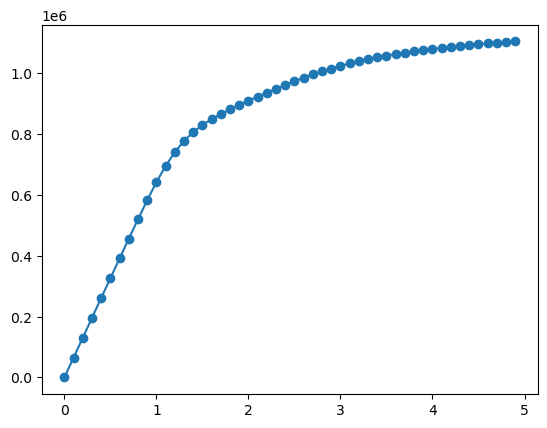

In [94]:
plt.scatter(
    x = np.array(radius_paths),
    y = np.array(graph_connections)
)

plt.plot(
    np.array(radius_paths), 
    np.array(graph_connections)
)
plt.show()

In [98]:
data

HeteroData(
  pano={ x=[52298, 38] },
  footprint={ x=[500, 64] },
  (footprint, contains, pano)={ edge_index=[2, 729] },
  (pano, links, pano)={ edge_index=[2, 907807] }
)